In [1]:
#importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt

# Loading Datasets

In [2]:
data_movie = pd.read_csv("movie.csv") #Datset eccontaining movie names
data_rating = pd.read_csv("rating.csv") #Dataset with rating of the movies given by each user

# Data Modelling

In [3]:
data_movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data_movie.shape

(27278, 3)

In [5]:
#n collaborative filtering we dont ned the content of the item.
data_movie.drop(['genres'],axis=1,inplace=True)

In [6]:
data_rating.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [7]:
#droping timesttamp column
data_rating = data_rating.loc[:,["userId","movieId","rating"]]
data_rating.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


We will merge the movie and rating dataset


In [8]:
df = pd.merge(data_movie,data_rating)
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),3,4.0
1,1,Toy Story (1995),6,5.0
2,1,Toy Story (1995),8,4.0
3,1,Toy Story (1995),10,4.0
4,1,Toy Story (1995),11,4.5


In [9]:
df.describe()

,movieId,userId,rating
count,4.874258e+06,4.874258e+06,4.874258e+06
mean,9.066614e+03,1.658677e+04,3.520725e+00
std,1.977110e+04,9.634588e+03,1.052793e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,9.040000e+02,8.349000e+03,3.000000e+00
50%,2.174000e+03,1.648800e+04,3.500000e+00
75%,4.812000e+03,2.490300e+04,4.000000e+00
max,1.312580e+05,3.349700e+04,5.000000e+00


# Analysing the data

The movies which have been rated by most number of users:

In [10]:
df.groupby("title").count()["rating"].sort_values(ascending=False).head(20)

title
Pulp Fiction (1994)                                      16295
Forrest Gump (1994)                                      16095
Shawshank Redemption, The (1994)                         15402
Silence of the Lambs, The (1991)                         15232
Jurassic Park (1993)                                     14559
Star Wars: Episode IV - A New Hope (1977)                13328
Braveheart (1995)                                        12999
Terminator 2: Judgment Day (1991)                        12809
Matrix, The (1999)                                       12521
Schindler's List (1993)                                  12269
Toy Story (1995)                                         12009
Fugitive, The (1993)                                     11994
Apollo 13 (1995)                                         11517
Independence Day (a.k.a. ID4) (1996)                     11463
Star Wars: Episode VI - Return of the Jedi (1983)        11460
Usual Suspects, The (1995)                       

In [11]:
df.groupby("title").count()["rating"].sort_values(ascending=False).tail(20)

title
I Will Buy You (Anata kaimasu) (1956)                                       1
I Will Follow You Into the Dark (2012)                                      1
I as in Icarus (I... comme Icare) (1979)                                    1
I giorni contati (1963)                                                     1
I'm Here (2010)                                                             1
I, Monster (1971)                                                           1
ID:A (2011)                                                                 1
Ichi (2008)                                                                 1
If I Want to Whistle, I Whistle (Eu cand vreau sa fluier, fluier) (2010)    1
Immortal Story, The (Histoire immortelle) (1968)                            1
If It's Tuesday, This Must Be Belgium (1969)                                1
Illegal (1955)                                                              1
Illegal (2011)                                            

There are some movies with very few user ratings.
Similarly there are users who gave rating to very few movies.
This may cause inaccuracy in the code.
So deleting the movies with less than 200 reviews and deleting users who gave less 100 reviews would increase the accuracy of the model.

In [12]:
counts1 = df['userId'].value_counts()
df = df[df['userId'].isin(counts1[counts1 >= 100].index)]

counts2 = df['movieId'].value_counts()
df =df[df['movieId'].isin(counts2[counts2 >= 200].index)]

Checking the most common rating given by users:

<function matplotlib.pyplot.show>

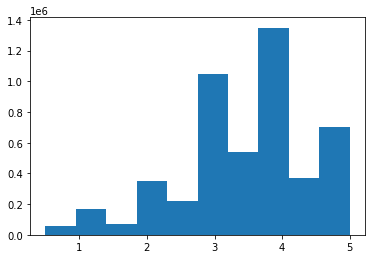

In [29]:
plt.hist(data_rating['rating'])
plt.show

Observation: 3-4 is the most common rating of the movies

Checking mean rating of the movies

(array([   9.,   18.,   67.,  159.,  396.,  712., 1108., 1343., 1061.,
         129.]),
 array([1.        , 1.34525386, 1.69050773, 2.03576159, 2.38101545,
        2.72626932, 3.07152318, 3.41677704, 3.76203091, 4.10728477,
        4.45253863]),
 <a list of 10 Patch objects>)

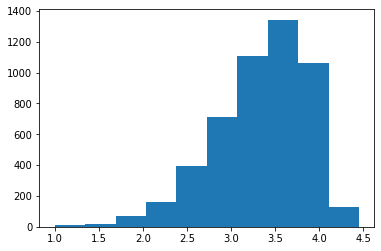

In [30]:
plt.hist(df.groupby("title").mean()['rating'].sort_values(ascending=False))

As we can see that the ratings and mean ratings are fairly distrubuted, which makes it great for recommendations.

# Recommending Movies With KNN

In [31]:
# Libraries for Recommendation System
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

Building a user vs item matrix

In [32]:
user_movie_table = df.pivot_table(index = ["title"],columns = ["userId"],values = "rating").fillna(0)
user_movie_table.head(10)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,33458,33459,33460,33461,33462,33463,33464,33465,33466,33467,33468,33469,33470,33471,33472,33473,33474,33475,33476,33477,33478,33479,33480,33481,33482,33483,33484,33485,33486,33487,33488,33489,33490,33491,33492,33493,33494,33495,33496,33497
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'burbs, The (1989)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
*batteries not included (1987),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...And Justice for All (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Items or Less (2006),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.5,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0
"10,000 BC (2008)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
import numpy as np
query_index = np.random.choice(user_movie_table.shape[0])
print(user_movie_table.index[query_index])

Thumbelina (1994)


In [35]:
user_movie_table_matrix = csr_matrix(user_movie_table.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_movie_table_matrix)
distances, indices = model_knn.kneighbors(user_movie_table.iloc[query_index,:].values.reshape(1, -1), n_neighbors =11)

In [36]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(user_movie_table.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, user_movie_table.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Thumbelina (1994):

1: Swan Princess, The (1994), with distance of 0.7404354746412227:
2: Great Mouse Detective, The (1986), with distance of 0.7489736846617997:
3: Pagemaster, The (1994), with distance of 0.7589186189770069:
4: Rescuers Down Under, The (1990), with distance of 0.7688866760641719:
5: Anastasia (1997), with distance of 0.7778692073016275:
6: Ferngully: The Last Rainforest (1992), with distance of 0.7807572730438272:
7: Quest for Camelot (1998), with distance of 0.7860042157038845:
8: Rescuers, The (1977), with distance of 0.7877410497233691:
9: King and I, The (1999), with distance of 0.8037317080654067:
10: Return of Jafar, The (1994), with distance of 0.8037951134122212:
